<a href="https://www.kaggle.com/code/opeyemiogunniyi/fuel-consumption-analysis?scriptVersionId=106352223" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fuelconsumption/Consumption.csv


## Fuel Consumption Analysis

### This dataset will be subjected to three different methods of regression analysis:
1. Simple Linear Regression
2. Multiple Linear Regression
3. Polynomial Regression

### Importing Needed packages

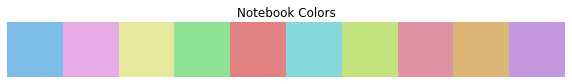

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline


from pandas_profiling import ProfileReport

import seaborn as sns
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from plotly.subplots import make_subplots
%matplotlib inline
colors = ['#7DBCE6','#E6ABE6','#E7E89E','#8FE195','#E28181',
          '#87D8DB','#C2E37D','#DF93A4','#DCB778','#C497DE']
sns.palplot(sns.color_palette(colors))
plt.title('Notebook Colors', size = 12)
plt.axis('off')
plt.show()

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.base import  clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  ElasticNet)

<h2 id="understanding_data">Understanding the Data</h2>

### `FuelConsumption.csv`:

We have downloaded a fuel consumption dataset, **`FuelConsumption.csv`**, which contains model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada. [Dataset source](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01)

*   **MODELYEAR** e.g. 2014
*   **MAKE** e.g. Acura
*   **MODEL** e.g. ILX
*   **VEHICLE CLASS** e.g. SUV
*   **ENGINE SIZE** e.g. 4.7
*   **CYLINDERS** e.g 6
*   **TRANSMISSION** e.g. A6
*   **FUELTYPE** e.g. z
*   **FUEL CONSUMPTION in CITY(L/100 km)** e.g. 9.9
*   **FUEL CONSUMPTION in HWY (L/100 km)** e.g. 8.9
*   **FUEL CONSUMPTION COMB (L/100 km)** e.g. 9.2
*   **CO2 EMISSIONS (g/km)** e.g. 182   --> low --> 0


### Reading the data in

In [3]:
df = pd.read_csv(r'../input/fuelconsumption/Consumption.csv')

# take a look at the dataset
df.head()

MODELYEAR   MAKE       MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2014  ACURA         ILX      COMPACT         2.0          4   
1       2014  ACURA         ILX      COMPACT         2.4          4   
2       2014  ACURA  ILX HYBRID      COMPACT         1.5          4   
3       2014  ACURA     MDX 4WD  SUV - SMALL         3.5          6   
4       2014  ACURA     RDX AWD  SUV - SMALL         3.5          6   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AS5        Z                   9.9                  6.7   
1           M6        Z                  11.2                  7.7   
2          AV7        Z                   6.0                  5.8   
3          AS6        Z                  12.7                  9.1   
4          AS6        Z                  12.1                  8.7   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.5                        33           196  
1                   9.6                        29           221  
2                   5.9                        48           136  
3                  11.1                        25           255  
4                  10.6                        27           244

## Data Exploration

Let's first have a descriptive exploration on our data.

In [4]:
#Check the number of columns and rows
df.shape

(1067, 13)

There are 1067 rows and 13 columns


In [5]:
#Check data for null values
df.isnull().any()

MODELYEAR                   False
MAKE                        False
MODEL                       False
VEHICLECLASS                False
ENGINESIZE                  False
CYLINDERS                   False
TRANSMISSION                False
FUELTYPE                    False
FUELCONSUMPTION_CITY        False
FUELCONSUMPTION_HWY         False
FUELCONSUMPTION_COMB        False
FUELCONSUMPTION_COMB_MPG    False
CO2EMISSIONS                False
dtype: bool

There is no null value in the data


In [6]:
#Check datatypes of the columns
df.dtypes

MODELYEAR                     int64
MAKE                         object
MODEL                        object
VEHICLECLASS                 object
ENGINESIZE                  float64
CYLINDERS                     int64
TRANSMISSION                 object
FUELTYPE                     object
FUELCONSUMPTION_CITY        float64
FUELCONSUMPTION_HWY         float64
FUELCONSUMPTION_COMB        float64
FUELCONSUMPTION_COMB_MPG      int64
CO2EMISSIONS                  int64
dtype: object

In [7]:
# summarize the data
df.describe()

MODELYEAR   ENGINESIZE    CYLINDERS  FUELCONSUMPTION_CITY  \
count     1067.0  1067.000000  1067.000000           1067.000000   
mean      2014.0     3.346298     5.794752             13.296532   
std          0.0     1.415895     1.797447              4.101253   
min       2014.0     1.000000     3.000000              4.600000   
25%       2014.0     2.000000     4.000000             10.250000   
50%       2014.0     3.400000     6.000000             12.600000   
75%       2014.0     4.300000     8.000000             15.550000   
max       2014.0     8.400000    12.000000             30.200000   

       FUELCONSUMPTION_HWY  FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  \
count          1067.000000           1067.000000               1067.000000   
mean              9.474602             11.580881                 26.441425   
std               2.794510              3.485595                  7.468702   
min               4.900000              4.700000                 11.000000   
25%               7.500000              9.000000                 21.000000   
50%               8.800000             10.900000                 26.000000   
75%              10.850000             13.350000                 31.000000   
max              20.500000             25.800000                 60.000000   

       CO2EMISSIONS  
count   1067.000000  
mean     256.228679  
std       63.372304  
min      108.000000  
25%      207.000000  
50%      251.000000  
75%      294.000000  
max      488.000000

In [8]:
 df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
#Check Variable Types

def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                               'Classes': [dataframe[i].nunique() \
                                           for i in dataframe.columns]})

    nunique_df = nunique_df.sort_values('Classes', ascending=False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

Variable  Classes
0                      MODEL      663
1       FUELCONSUMPTION_CITY      167
2               CO2EMISSIONS      159
3       FUELCONSUMPTION_COMB      148
4        FUELCONSUMPTION_HWY      118
5                 ENGINESIZE       45
6   FUELCONSUMPTION_COMB_MPG       43
7                       MAKE       39
8               TRANSMISSION       22
9               VEHICLECLASS       16
10                 CYLINDERS        7
11                  FUELTYPE        4
12                 MODELYEAR        1

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 1067
Variables: 13
cat_cols: 4
num_cols: 6
cat_but_car: 3
num_but_cat: 2


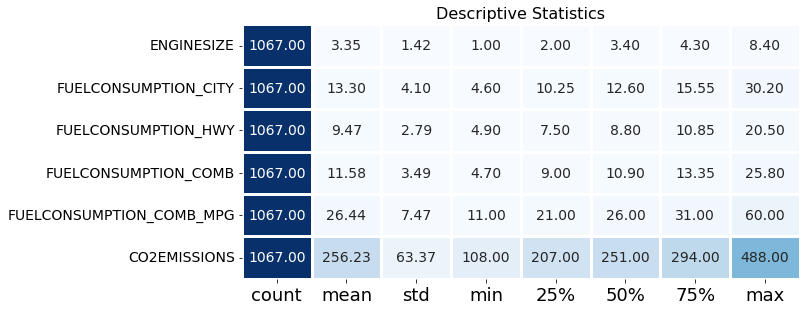

In [11]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Blues",
                fmt= '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.3,
                cbar = False,
                annot_kws = {"size": 14})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 16)
    plt.show()
    
desc_stats(df[num_cols])

In [12]:
def cat_summary(dataframe, col_name):
    
    get_labels = lambda x: x.value_counts().keys()
    get_values = lambda x: x.value_counts().values
    
    fig = make_subplots(rows = 1,cols = 2,
                        subplot_titles = ('Countplot','Percentages'),
                        specs = [[{"type": "xy"}, {'type':'domain'}]])

    fig.add_trace(go.Bar( y = get_values(dataframe[col_name]).tolist(), 
                          x = [str(i) for i in dataframe[col_name].value_counts().index], 
                          text = get_values(dataframe[col_name]).tolist(),
                          textfont = dict(size = 14),
                          name = col_name,
                          textposition = 'auto',
                          marker = dict(color = colors),
                          showlegend=False),
                  row = 1, col = 1)
    
    fig.add_trace(go.Pie(labels = get_labels(dataframe[col_name]),
                         values = get_values(dataframe[col_name]),
                         textfont = dict(size = 14),
                         textposition='auto',
                         showlegend = False,
                         name = col_name,
                         marker = dict(colors = colors)
                        ),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': col_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    
    iplot(fig)

for col in cat_cols:
    cat_summary(df, col)


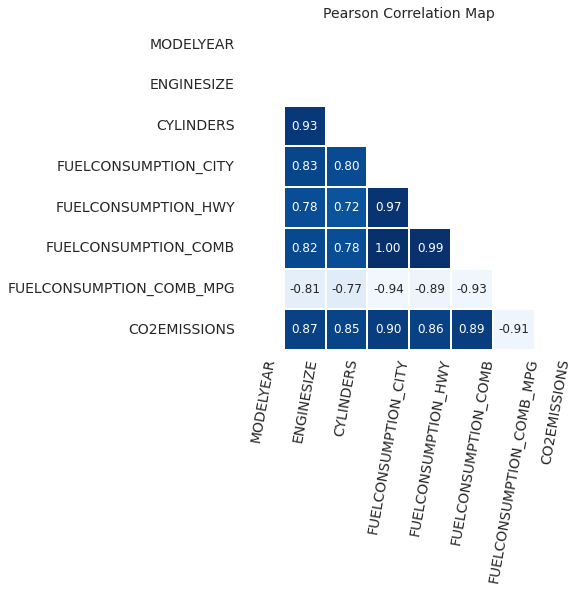

In [13]:
def corr_map(dataframe, method = 'pearson', title = None):
    assert method in ['pearson', 'spearman'], 'Invalid Correlation Method'
    sns.set_style("white")
    matrix = np.triu(dataframe.corr(method=method))
    f,ax=plt.subplots(figsize = (matrix.shape[0]*0.75,
                                 matrix.shape[1]*0.75))
    sns.heatmap(dataframe.corr(method=method),
                annot= True,
                fmt = ".2f",
                cbar = False,
                ax=ax,
                vmin = -1,
                vmax = 1,
                mask = matrix,
                cmap = "Blues",
                linewidth = 0.4,
                linecolor = "white",
                annot_kws={"size": 12})
    plt.xticks(rotation=80,size=14)
    plt.yticks(rotation=0,size=14)
    if title == None:
        title = f'{method.title()} Correlation Map'
    plt.title(title, size = 14)
    plt.show()
    
corr_map(df)

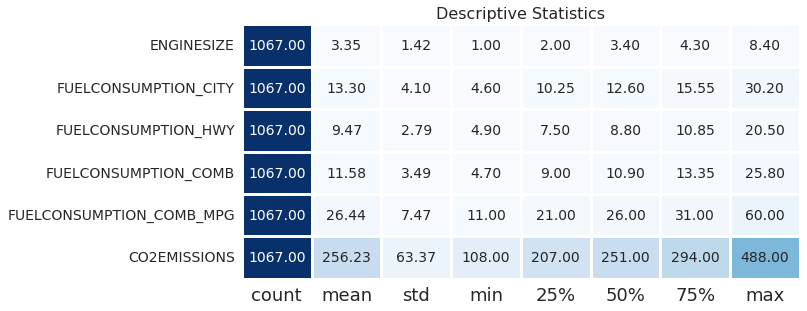

In [14]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1 = q1, q3 = q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in df[num_cols].columns:
    replace_with_thresholds(df, col, q1 = 0.1, q3 = 0.9)
    
desc_stats(df[num_cols])

In [15]:
# Let's select some features that we want to use for regression.

cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head(9)

ENGINESIZE  CYLINDERS  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0         2.0          4                   9.9                  6.7   
1         2.4          4                  11.2                  7.7   
2         1.5          4                   6.0                  5.8   
3         3.5          6                  12.7                  9.1   
4         3.5          6                  12.1                  8.7   
5         3.5          6                  11.9                  7.7   
6         3.5          6                  11.8                  8.1   
7         3.7          6                  12.8                  9.0   
8         3.7          6                  13.4                  9.5   

   FUELCONSUMPTION_COMB  CO2EMISSIONS  
0                   8.5         196.0  
1                   9.6         221.0  
2                   5.9         136.0  
3                  11.1         255.0  
4                  10.6         244.0  
5                  10.0         230.0  
6                  10.1         232.0  
7                  11.1         255.0  
8                  11.6         267.0

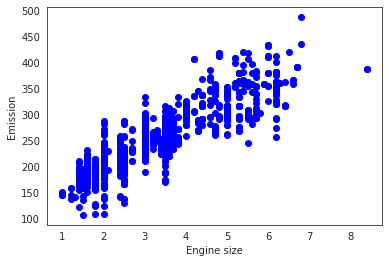

In [16]:
# Let's plot Emission values with respect to Engine size:

plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### Creating train and test dataset

Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set.
This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the model. Therefore, it gives us a better understanding of how well our model generalizes on new data.

We know the outcome of each data point in the testing dataset, making it great to test with! Since this data has not been used to train the model, the model has no knowledge of the outcome of these data points. So, in essence, it is truly an out-of-sample testing.

Let's split our dataset into train and test sets. Around 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using the  **np.random.rand()** function:


In [17]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

### Train data distribution

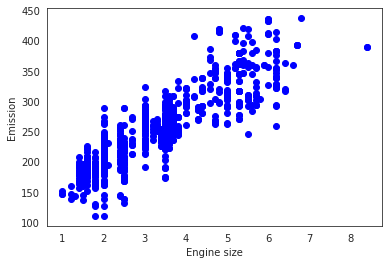

In [18]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

# Simple Regression Model
Linear Regression fits a linear model with coefficients B = (B1, ..., Bn) to minimize the 'residual sum of squares' between the actual value y in the dataset, and the predicted value yhat using linear approximation.

In [19]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit(train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[39.11829322]]
Intercept:  [124.7487714]


#### Evaluation
​
We compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.
​
There are different model evaluation metrics, lets use MSE here to calculate the accuracy of our model based on the test set:
​
*   Mean Absolute Error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
​
*   Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean Absolute Error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
​
*   Root Mean Squared Error (RMSE).
​
*   R-squared is not an error, but rather a popular metric to measure the performance of your regression model. It represents how close the data points are to the fitted regression line. The higher the R-squared value, the better the model fits your data. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [20]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y , test_y_) )

Mean absolute error: 23.64
Residual sum of squares (MSE): 958.92
R2-score: 0.77


# Multiple Regression Model

In reality, there are multiple variables that impact the co2emission. When more than one independent variable is present, the process is called multiple linear regression. An example of multiple linear regression is predicting co2emission using the features FUELCONSUMPTION_COMB, EngineSize and Cylinders of cars. The good thing here is that multiple linear regression model is the extension of the simple linear regression model.

In [21]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(train[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asanyarray(train[['CO2EMISSIONS']])
regr.fit (x, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[10.31405409  8.26535669  9.45914238]]


As mentioned before, **Coefficient** and **Intercept**  are the parameters of the fitted line.
Given that it is a multiple linear regression model with 3 parameters and that the parameters are the intercept and coefficients of the hyperplane, sklearn can estimate them from our data. Scikit-learn uses plain Ordinary Least Squares method to solve this problem.

#### Ordinary Least Squares (OLS)

OLS is a method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by minimizing the sum of the squares of the differences between the target dependent variable and those predicted by the linear function. In other words, it tries to minimizes the sum of squared errors (SSE) or mean squared error (MSE) between the target variable (y) and our predicted output ($\hat{y}$) over all samples in the dataset.

OLS can find the best parameters using of the following methods:

*   Solving the model parameters analytically using closed-form equations
*   Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, etc.)


## Prediction

In [22]:
y_hat= regr.predict(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
x = np.asanyarray(test[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']])
y = np.asanyarray(test[['CO2EMISSIONS']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x, y))

Residual sum of squares: 524.19
Variance score: 0.87


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



# Polynomial Regression

In [23]:
cdf = df[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB','CO2EMISSIONS']]
cdf.head(9)

ENGINESIZE  CYLINDERS  FUELCONSUMPTION_COMB  CO2EMISSIONS
0         2.0          4                   8.5         196.0
1         2.4          4                   9.6         221.0
2         1.5          4                   5.9         136.0
3         3.5          6                  11.1         255.0
4         3.5          6                  10.6         244.0
5         3.5          6                  10.0         230.0
6         3.5          6                  10.1         232.0
7         3.7          6                  11.1         255.0
8         3.7          6                  11.6         267.0

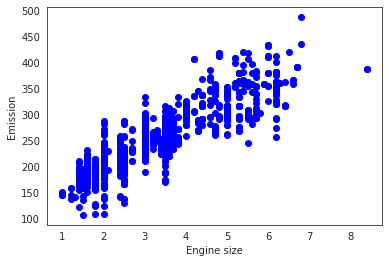

In [24]:
#Let's plot Emission values with respect to Engine size:

plt.scatter(cdf.ENGINESIZE, cdf.CO2EMISSIONS,  color='blue')
plt.xlabel("Engine size")
plt.ylabel("Emission")
plt.show()

#### Creating train and test dataset

Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set.

In [25]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
train_x = np.asanyarray(train[['ENGINESIZE']])
train_y = np.asanyarray(train[['CO2EMISSIONS']])

test_x = np.asanyarray(test[['ENGINESIZE']])
test_y = np.asanyarray(test[['CO2EMISSIONS']])


poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(train_x)
train_x_poly

array([[ 1.  ,  2.4 ,  5.76],
       [ 1.  ,  1.5 ,  2.25],
       [ 1.  ,  3.5 , 12.25],
       ...,
       [ 1.  ,  3.  ,  9.  ],
       [ 1.  ,  3.2 , 10.24],
       [ 1.  ,  3.2 , 10.24]])

In [27]:
clf = linear_model.LinearRegression()
train_y_ = clf.fit(train_x_poly, train_y)
# The coefficients
print ('Coefficients: ', clf.coef_)
print ('Intercept: ',clf.intercept_)

Coefficients:  [[ 0.         48.81939965 -1.23102224]]
Intercept:  [109.74652721]


Text(0, 0.5, 'Emission')

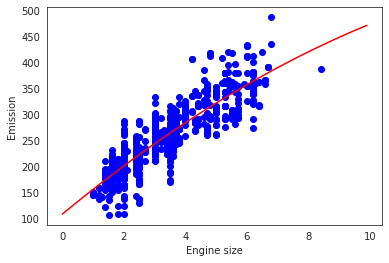

In [28]:
plt.scatter(train.ENGINESIZE, train.CO2EMISSIONS,  color='blue')
XX = np.arange(0.0, 10.0, 0.1)
yy = clf.intercept_[0]+ clf.coef_[0][1]*XX+ clf.coef_[0][2]*np.power(XX, 2)
plt.plot(XX, yy, '-r' )
plt.xlabel("Engine size")
plt.ylabel("Emission")

In [29]:
#Evaluation

from sklearn.metrics import r2_score

test_x_poly = poly.transform(test_x)
test_y_ = clf.predict(test_x_poly)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y,test_y_ ) )

Mean absolute error: 24.26
Residual sum of squares (MSE): 1024.21
R2-score: 0.76
